In [1]:
from triqs.gf import *
from triqs.operators import *
from triqs.operators.util.hamiltonians import h_int_kanamori, h_int_slater
from triqs.operators.util import *
from triqs.operators.util.hamiltonians import *

from h5 import HDFArchive
from triqs.atom_diag import *
import numpy as np
#import sympy as sp
from itertools import product
import matplotlib.pylab as plt

In [2]:
spin_names = ('up','dn')
orb_names = [0, 1]
fops = [(sn,on) for sn, on in product(spin_names,orb_names)]

beta = 1e24
target_occ = 2

U = 5.0
Ul = 2.5
t = 1.0
eps = 4.0


def get_G_w(t, eps, U, Ul):
    mu = 10.0

    uijkl = np.zeros((2,2,2,2))
    uijkl[0,0,0,0] = U
    uijkl[0,1,0,1] = Ul
    uijkl[1,0,1,0] = Ul
    uijkl[1,1,1,1] = U

    N_up = n('up',0) + n('up',1)
    N_dn = n('dn',0) + n('dn',1)
    N = N_up + N_dn
    H = mu * N
    
    for s in spin_names:
        for i in range(len(orb_names)):
            H += -t * (c_dag(s, i)*c(s, (i+1)%len(orb_names)))


    H += h_int_slater(spin_names, orb_names, uijkl, off_diag=True, complex=True)

    for s in spin_names:
        for o in orb_names:
            H += eps*(n(s, o))
            
    step = 0.1
    while True:

        H += mu * N
        ad = AtomDiagComplex(H, fops, n_min=target_occ-1, n_max=target_occ+1)
        
        dm = atomic_density_matrix(ad, beta)
        
        filling = trace_rho_op(dm, N, ad)

        if abs(filling.real-target_occ) < 1.0e-6:
            break
        elif filling.real < target_occ:
            H += -mu * N
            mu+=-step
        elif filling.real > target_occ:
            H += -mu * N
            mu+=step
            
    gf_struct = [('dn', len(orb_names)),('up', len(orb_names))]
    
    G_w = atomic_g_w(ad, beta, gf_struct, (-3, 12), 700, 0.1)
    return G_w

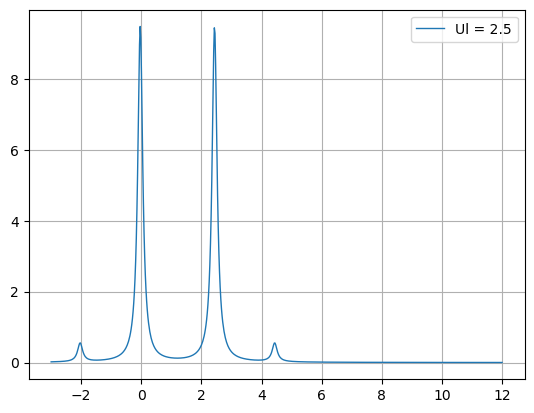

In [4]:

plt.figure(1)
plt.clf()
plt.grid(True)


G_w = get_G_w(1.0, 0.0, 2.0, 0.0)

f = np.array(list(G_w['up'].mesh.values()))

plt.plot(f, -np.imag(np.trace(G_w['up'].data[:,:,:], axis1=1, axis2=2)), linewidth = 1, label = "Ul = {}".format(Ul)) 
plt.legend()    
plt.show()

We construct the Hubbard dimer Hamiltonian:
\begin{align}
\hat{H}=&\ -t(\hat{c}_{1,\uparrow}^\dagger \hat{c}_{2,\uparrow}+\hat{c}_{2,\uparrow}^\dagger \hat{c}_{1,\uparrow}+\hat{c}_{1,\downarrow}^\dagger \hat{c}_{2,\downarrow}+\hat{c}_{2,\downarrow}^\dagger \hat{c}_{1,\downarrow}) + U(\hat{c}_{1,\uparrow}^\dagger \hat{c}_{1,\uparrow}\hat{c}_{1,\downarrow}^\dagger \hat{c}_{1,\downarrow}+\hat{c}_{2,\uparrow}^\dagger \hat{c}_{2,\uparrow}\hat{c}_{2,\downarrow}^\dagger \hat{c}_{2,\downarrow})\\
&+ \varepsilon_0(\hat{c}_{1,\uparrow}^\dagger\hat{c}_{1,\uparrow}+\hat{c}_{1,\downarrow}^\dagger\hat{c}_{1,\downarrow}+\hat{c}_{2,\uparrow}^\dagger\hat{c}_{2,\uparrow}+\hat{c}_{2,\downarrow}^\dagger\hat{c}_{2,\downarrow})\notag\\
&+\ U_l(\hat{c}_{1,\uparrow}^\dagger\hat{c}_{1,\uparrow}\hat{c}_{2,\uparrow}^\dagger\hat{c}_{2,\uparrow}+\hat{c}_{1,\uparrow}^\dagger\hat{c}_{1,\uparrow}\hat{c}_{2,\downarrow}^\dagger\hat{c}_{2,\downarrow} + \hat{c}_{1,\downarrow}^\dagger\hat{c}_{1,\downarrow}\hat{c}_{2,\uparrow}^\dagger\hat{c}_{2,\uparrow}+\hat{c}_{1,\downarrow}^\dagger\hat{c}_{1,\downarrow}\hat{c}_{2,\downarrow}^\dagger\hat{c}_{2,\downarrow})
\end{align}
Here $t$ is the hopping integral, $U$ the on-site coulomb term, $U_l$ the long-range coulomb term between sites and $\varepsilon_0$ the orbital energy.

What exactly is the atomic density matrix? Is it this?
$$\rho=\dfrac{1}{Z}e^{-\beta (H-\mu N)}\dfrac{1}{\text{Tr}e^{-\beta(H-\mu N)}}e^{-\beta (H-\mu N)}$$
And I then take it that function 'trace_rho_op' computes
$$\langle A\rangle=\text{Tr}(\rho A)$$
Such that for the filling we have:
$$\langle N\rangle=\text{Tr}(\rho N)$$
Though I don't know what we'd need 'ad' again as an argument, shouldn't all be contained in the density matrix

And what are we actually plotting? I assume it's the spectal function but the spectral function is just imaginary part of the Green function (with a factor). So why are we taking a trace?

And assuming I've implemented the long-range coulomb term correctly, how do we interpret the results? It seems like for a stronger coulomb interaction that the two smaller peaks dissapear and the two larger ones move away from eachother. I take it we can conclude that this means those transitions become less and less likely while one transition becomes higher and higher in energy.